In [156]:
# Imports and config
import csv
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
sns.set(color_codes=True)
import ipywidgets as widgets
%config InlineBackend.close_figures = False
# CONFIG
# should these be global constants? might cause problems with loading different files
# -> maybe make a class jube_result containing the DataFrame and these constants
TIME = 'time' # column name of time measurements, only for non-mono
MEAS = 'filename' # column name of measurement names, only for non-mono
MPI = 'mpi_num_procs' # column name of mpi_num_procs
OMP = 'omp_num_threads' # column name of omp_num_threads
CORES = 'total_cores' # column name of number of used cores

FEATURES = [] # List of all columns, generated by load method
MEASUREMENTS = [] # List of all distinct values of column specified by MEAS, generated by load method

pdIDX = pd.IndexSlice # for advanced indexing

In [157]:
# Functions
def load_jube_results_mono(file, delimiter=',', index_col=[0,1,2,3,4,5]):
    """
    Loads Data from JUBE_template_mono result csv.
    index_col: specfies the columns which contain the configuration, ie every column that does not conatin a measured time.
        Must be an Iterable (eg a List)
        default: the first six columns
    returned DataFrame 
    """
    data=pd.read_csv(path,delimiter=delimiter, index_col=index_col) # How to get index_col??
    data.columns = [string.split('[')[0] for string in data.columns]
    
    FEATURES=list(data.index.names)
    MEASUREMENTS=list(data.columns)
    return data, FEATURES, MEASUREMENTS

def load_jube_results(file, delimiter=',', drop_measurements=[]):
    """
    Loads Data from JUBE_template result csv.
    drop_measurements: specfies files with unnecessary time measurements, eg init. Must be an Iterable (eg a List)
    """
    base_csv = pd.read_csv(file, delimiter=delimiter)
    base_csv.replace(inplace=True, to_replace="$extract_time", value=np.nan) # disregards unsuccessful measurements
    base_csv[TIME] = base_csv[TIME].astype('float64', copy=False) # time needs to be a float to allow aggregation such as min/max 
    
    for drop in drop_measurements: # drop drop_measurements
        base_csv = base_csv[ base_csv[MEAS] != drop ]
        
    # every column that isnt a time measurement or a name of a time measurement is a feature
    FEATURES = [column for column in base_csv if column != TIME and column != MEAS]
    MEASUREMENTS = list(base_csv[MEAS].unique())
    
    def transpose_file_time(data):
        """
        transpose filename and time for better readabiliy
        """
        return pd.pivot_table(data, columns=[MEAS], index=FEATURES)
    table = transpose_file_time(base_csv)
    table.columns=list(table.columns.get_level_values(1))
    return table, FEATURES, MEASUREMENTS

def add_agg(data, name, aggfunc=np.sum):
    """
    Adds an aggregated column to data.
    data: DataFrame to which the column is added
    name: name of the added column
    aggfunc: function for aggregating the values
    """
    #MEASUREMENTS.append(name)
    data[name]=data.agg( func=aggfunc, axis=1 )
    return data

def heatmaps(table, aggfunc=np.min, serialRuntimes=None, color_scale=2., annot=True): #, columns=[OMP], rows=[MPI], , 
    """
    Speedup Heatmaps for each File, by mpi and omp.
    color_scale: sets the scaling on the color_bar, default is 2 ie quadratic.
    aggfunc: used, when columns and index yield more than one element
    columns: columns of the heatmaps
    rows: rows of the heatmaps
    """
    cols = widgets.ToggleButtons( options=FEATURES, description="columns:", value=OMP)
    rows = widgets.ToggleButtons( options=FEATURES, description="rows:", value=MPI)
    cs = widgets.FloatSlider(min=0.4, max=4., step=0.2, value=color_scale, description='color exp.')
    
    table=table.reset_index()
    if serialRuntimes is None:
        serialRuntimes={ measurement:
                        table.loc[ (table[CORES] == table[CORES].min()), measurement ].aggregate(aggfunc) 
                        for measurement in MEASUREMENTS }
    OUT={measurement:None for measurement in MEASUREMENTS}
    
    def show_heatmap(cols, rows, color_scale):
        np.warnings.filterwarnings('ignore') # ignore warings during heatmap creation
        
        for measurement in MEASUREMENTS:
            data = pd.pivot_table( table, columns=[cols], index=[rows], aggfunc=aggfunc)[measurement]
            data = pd.DataFrame(serialRuntimes[measurement] / data.values, columns=data.columns, index=data.index) # calculate speedup

            OUT[measurement] = sns.heatmap(data=data,
                                annot=annot,
                                cmap=sns.color_palette("GnBu_d",n_colors=data.size),
                                norm=colors.PowerNorm(gamma=color_scale, vmin=0, vmax=20, clip=False),
                                linecolor='white',
                                linewidth=1,#2
                                vmin=data.min().min(),
                                vmax=data.max().max(),
                               ).figure
            plt.title('Speedup: ' + measurement.split('[')[0], size=14)
            plt.show()
            plt.close('all')
            
        np.warnings.filterwarnings('always')
        
    widgets.interact(show_heatmap, cols=cols, rows=rows, color_scale=cs)
    return OUT
        
def pairplots(table, aggfunc=None):
    """
    Interactive Pairplot for individual runtimes by feature.
    """
    table = table.reset_index()
    
    sel_features = widgets.SelectMultiple(options=FEATURES, description="Features:", value=FEATURES[:len(FEATURES)//2])
    hue          = widgets.ToggleButtons( options=FEATURES + [None], description="Hue:", value=None)

    OUT=[None]
    def show_hue(hue, sel_features):
        data = table
        """
        if hue is not None and aggfunc is not None: #aggregate for hue
            data=data.set_index([ feature for feature in sel_features if feature is not hue])
            data=data.aggregate(aggfunc, axis='index')
            data=pd.DataFrame(data)
            print(data.head())
        """
        #global OUT
        OUT[0]=sns.pairplot(
                 data     =data, # define subset of data
                 x_vars   =sel_features, # alle relevanten features, selected by widgets.SelectMultiple
                 y_vars   =MEASUREMENTS, # alle Zeitmessungen
                 hue      =hue, 
                 plot_kws ={'alpha':0.6}, # plot config
                 size     =3,
                )
        #plt.show()
    widgets.interact(show_hue, hue=hue, sel_features=sel_features)
    plt.close('all')
    plt.show()
    return OUT[0]#show_hue(hue=hue.value, sel_features=sel_features.value)

def savefigs(fig, name):
    plt.tight_layout()
    for fformat in ['png', 'pdf', 'svg']:
        fullName = name + '.' + fformat
        fig.savefig(fullName, format=fformat)
        print('saved',fullName)

In [158]:
# Load Data
path='timings/result_000007.dat'
table, FEATURES, MEASUREMENTS = load_jube_results_mono( path, ';', index_col=[0,1,2,3,4])
table = table.dropna()#.iloc[0]
table[table<1e-5] = np.inf  # wrong measurements
print('measured timings:', MEASUREMENTS)
print()
print('features:',FEATURES)
#table

measured timings: ['read_pfb', 'SubsurfaceStorage', 'SubsurfaceStorage_vectorized', 'TopLayerPressure', 'TopLayerPressure_vectorized', 'SurfaceStorage', 'VolumetricMoisture', 'OverlandFlow', 'NetLateralOverlandFlow', 'NetLateralOverlandFlow_vectorized', 'SubsurfaceFlow', 'SubsurfaceFlow_vectorized']

features: ['nodes', 'total_cores', 'mpi_num_procs', 'omp_num_threads', 'split']


In [159]:
table.reset_index()#.sort_index()

,nodes,total_cores,mpi_num_procs,omp_num_threads,split,read_pfb,SubsurfaceStorage,SubsurfaceStorage_vectorized,TopLayerPressure,TopLayerPressure_vectorized,SurfaceStorage,VolumetricMoisture,OverlandFlow,NetLateralOverlandFlow,NetLateralOverlandFlow_vectorized,SubsurfaceFlow,SubsurfaceFlow_vectorized
0,1,48,1,48,0,12.922077,1.248115,0.938376,1.334694,0.312096,0.176504,0.146667,0.927496,inf,0.717022,3.990343,inf
1,1,48,1,48,-1,22.519659,1.244345,0.933656,1.333127,0.311861,0.177457,0.146377,0.924884,inf,0.716784,3.952686,inf
2,1,48,2,24,-1,23.058529,0.646207,0.463710,0.687322,0.158770,0.090074,0.074577,0.524941,inf,0.448014,2.272782,inf
3,2,96,2,48,-1,12.365348,0.633315,0.474954,0.682604,0.160066,0.088759,0.073705,0.472763,inf,0.446290,2.049932,inf
4,2,96,4,24,-1,13.515219,0.332038,0.234219,0.350736,0.087439,0.045281,0.037152,0.261020,inf,0.249524,1.149445,inf
5,4,192,4,48,-1,16.161983,0.332709,0.238744,0.346166,0.084410,0.044623,0.036438,0.238498,inf,0.265795,1.059255,inf
6,4,192,8,24,-1,24.642183,0.177916,0.121375,0.186759,0.046437,0.023437,0.018821,0.146856,inf,0.154171,0.605725,inf
7,8,384,8,48,-1,18.871126,0.178161,0.122102,0.185492,0.054618,0.023003,0.018450,0.125123,inf,0.151143,0.543135,inf
8,8,384,16,24,-1,20.538276,0.125682,0.070791,0.103935,0.028753,0.011480,0.009537,0.073212,inf,0.147661,0.438741,inf


In [160]:
noind = table.reset_index()
noind['cores per node'] = noind[CORES] / noind['nodes']
FEATURES.append('cores per node')
#noind.sort_values(by='netCDF_read[sec]')
#table['matmul[sec]'].sort_values()

In [161]:
pairs=pairplots(noind);#[noind.split <2 ]

interactive(children=(ToggleButtons(description='Hue:', options=('nodes', 'total_cores', 'mpi_num_procs', 'omp…

In [162]:
# Speedups by file
hm=heatmaps(noind, aggfunc=np.min, color_scale=1,)

interactive(children=(ToggleButtons(description='columns:', index=3, options=('nodes', 'total_cores', 'mpi_num…

In [163]:
#for name in hm.keys():
#    #plt.show(hm[name])
#    savefigs(hm[name],'plots/comb-test03_heatmap_' + name.split('[')[0])

In [164]:
# Best configurations for each column
added = add_agg( table.replace(inplace=False, to_replace=np.nan, value=100), name='total', aggfunc=np.sum )
idx = added.idxmin(axis=0)
added.loc(axis=0)[idx]

read_pfb  \
nodes total_cores mpi_num_procs omp_num_threads split              
2     96          2             48              -1     12.365348   
8     384         16            24              -1     20.538276   
                                                -1     20.538276   
                                                -1     20.538276   
                                                -1     20.538276   
                                                -1     20.538276   
                                                -1     20.538276   
                                                -1     20.538276   
1     48          1             48               0     12.922077   
8     384         16            24              -1     20.538276   
                                                -1     20.538276   
1     48          1             48               0     12.922077   
                                                 0     12.922077   

                                                       SubsurfaceStorage  \
nodes total_cores mpi_num_procs omp_num_threads split                      
2     96          2             48              -1              0.633315   
8     384         16            24              -1              0.125682   
                                                -1              0.125682   
                                                -1              0.125682   
                                                -1              0.125682   
                                                -1              0.125682   
                                                -1              0.125682   
                                                -1              0.125682   
1     48          1             48               0              1.248115   
8     384         16            24              -1              0.125682   
                                                -1              0.125682   
1     48          1             48               0              1.248115   
                                                 0              1.248115   

                                                       SubsurfaceStorage_vectorized  \
nodes total_cores mpi_num_procs omp_num_threads split                                 
2     96          2             48              -1                         0.474954   
8     384         16            24              -1                         0.070791   
                                                -1                         0.070791   
                                                -1                         0.070791   
                                                -1                         0.070791   
                                                -1                         0.070791   
                                                -1                         0.070791   
                                                -1                         0.070791   
1     48          1             48               0                         0.938376   
8     384         16            24              -1                         0.070791   
                                                -1                         0.070791   
1     48          1             48               0                         0.938376   
                                                 0                         0.938376   

                                                       TopLayerPressure  \
nodes total_cores mpi_num_procs omp_num_threads split                     
2     96          2             48              -1             0.682604   
8     384         16            24              -1             0.103935   
                                                -1             0.103935   
                                                -1             0.103935   
                                                -1             0.103935   
                                                -1             

In [165]:
# Best runtimes for each column
#table.reset_index().set_index([ feature for feature in FEATURES if feature is not CORES and feature is not 'cores per node'])
table.aggregate(np.argmin, 0)
table

read_pfb  \
nodes total_cores mpi_num_procs omp_num_threads split              
1     48          1             48               0     12.922077   
                                                -1     22.519659   
                  2             24              -1     23.058529   
2     96          2             48              -1     12.365348   
                  4             24              -1     13.515219   
4     192         4             48              -1     16.161983   
                  8             24              -1     24.642183   
8     384         8             48              -1     18.871126   
                  16            24              -1     20.538276   

                                                       SubsurfaceStorage  \
nodes total_cores mpi_num_procs omp_num_threads split                      
1     48          1             48               0              1.248115   
                                                -1              1.244345   
                  2             24              -1              0.646207   
2     96          2             48              -1              0.633315   
                  4             24              -1              0.332038   
4     192         4             48              -1              0.332709   
                  8             24              -1              0.177916   
8     384         8             48              -1              0.178161   
                  16            24              -1              0.125682   

                                                       SubsurfaceStorage_vectorized  \
nodes total_cores mpi_num_procs omp_num_threads split                                 
1     48          1             48               0                         0.938376   
                                                -1                         0.933656   
                  2             24              -1                         0.463710   
2     96          2             48              -1                         0.474954   
                  4             24              -1                         0.234219   
4     192         4             48              -1                         0.238744   
                  8             24              -1                         0.121375   
8     384         8             48              -1                         0.122102   
                  16            24              -1                         0.070791   

                                                       TopLayerPressure  \
nodes total_cores mpi_num_procs omp_num_threads split                     
1     48          1             48               0             1.334694   
                                                -1             1.333127   
                  2             24              -1             0.687322   
2     96          2             48              -1             0.682604   
                  4             24              -1             0.350736   
4     192         4             48              -1             0.346166   
                  8             24              -1             0.186759   
8     384         8             48              -1             0.185492   
                  16            24              -1             0.103935   

                                                       TopLayerPressure_vectorized  \
nodes total_cores mpi_num_procs omp_num_threads split                                
1     48          1             48               0                        0.312096   
                                                -1                        0.311861   
                  2             24              -1                        0.158770   
2     96          2             48              -1                        0.160066   
                  4             24              -1                        0.087439   
4     192         4             48              -1                        0.084410  

In [166]:
# Get the five best configurations
agg=pd.DataFrame( table.replace(inplace=False, to_replace=np.inf, value=0).agg( func=np.sum,axis=1 ).sort_values(), columns=['total'])
agg.head()


total
nodes total_cores mpi_num_procs omp_num_threads split           
2     96          4             24              -1     16.262073
                  2             48              -1     17.447735
4     192         4             48              -1     18.808622
8     384         8             48              -1     20.272354
                  16            24              -1     21.548069

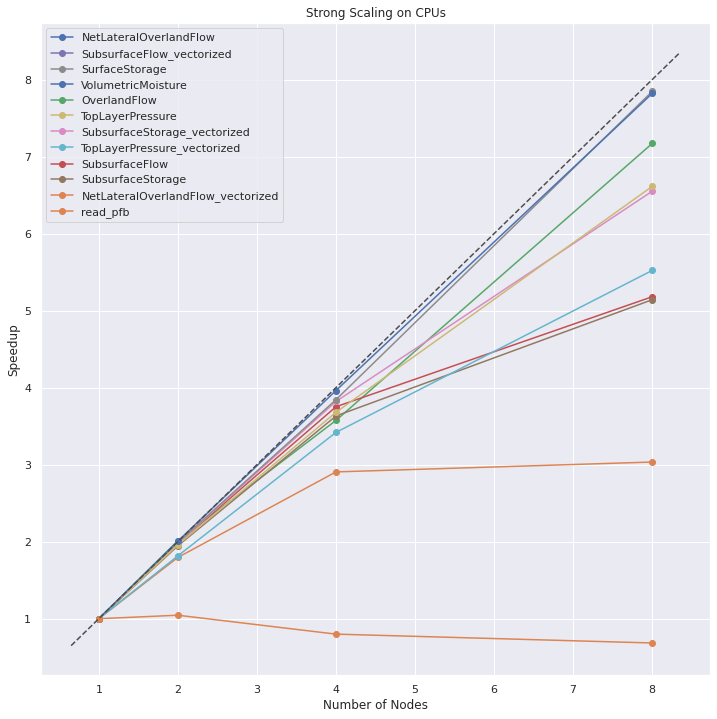

In [167]:
plt.close('all')
#[noind.total_cores == 24 * noind.nodes]
data = pd.pivot_table( pd.DataFrame(table), index=['nodes'], aggfunc=np.min)#.loc[pdIDX[:,:,:,:,1],:].dropna()
#print(data.iloc[0] / data)
#data = (data.iloc[:,:-1])
#print(ser[np.newaxis,:].shape, data.values.shape)
#print(ser[np.newaxis,:] / data.values)
ax = (data.iloc[0] / data).plot(marker='o', figsize=(12,12))
plt.ylabel('Speedup')
plt.xlabel('Number of Nodes')
plt.title('Strong Scaling on CPUs')
plt.plot(plt.xlim(), plt.xlim(), ls="--", c=".3")

# Sort the legend in descnding order
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[-1].get_ydata()[-1], reverse=True))
ax.legend(handles, labels)

plt.show()